## This notebook is used to parse the Index_history.txt files associated with the following two CMEMS datasets:

### CMEMS_dataset1:  INSITU_GLO_PHY_UV_DISCRETE_NRT_013_048
https://data.marine.copernicus.eu/product/INSITU_GLO_PHY_UV_DISCRETE_NRT_013_048/description
ftp://nrt.cmems-du.eu/Core/INSITU_GLO_PHY_UV_DISCRETE_NRT_013_048/cmems_obs-ins_glo_phy-cur_nrt_drifter_irr

### CMEMS_dataset2:  INSITU_GLO_PHYBGCWAV_DISCRETE_MYNRT_013_030
https://data.marine.copernicus.eu/product/INSITU_GLO_PHYBGCWAV_DISCRETE_MYNRT_013_030/description
ftp://nrt.cmems-du.eu/Core/INSITU_GLO_PHYBGCWAV_DISCRETE_MYNRT_013_030/cmems_obs-ins_glo_phybgcwav_mynrt_na_irr

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import collections
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from shapely.geometry import Point, Polygon
import xarray as xr
%matplotlib inline

drifter_dir = "C:/Users/HoldenJe/Drift/projects/gridded_velocity_products/drifter_data/CMEMS/"

cmems_dataset1 = "INSITU_GLO_PHY_UV_DISCRETE_NRT_013_048/"
cmems_dataset2 = "INSITU_GLO_PHYBGCWAV_DISCRETE_MYNRT_013_030/"

cmems_dataset1_datafile = os.path.join(drifter_dir, cmems_dataset1, "GL_TS_DC_1300636.nc")
cmems_dataset2_datafile = os.path.join(drifter_dir, cmems_dataset2, "GL_PR_BO_EXO10556.nc")  # or "GL_PR_BO_EXO11635.nc"

## First, parse the index_history.txt file to find the tracks that are in the correct date and geospatial range (i.e., 1993 to 2020 and on the NL/LAB Shelves) 

In [2]:
LatLonBoundingBox = collections.namedtuple('LatLonBoundingBox',
                                          ('minlon', 'maxlon', 'minlat', 'maxlat'))

shelf_coords = LatLonBoundingBox(minlon=-90, maxlon=-30, minlat=35, maxlat=80)
#shelf_coords = LatLonBoundingBox(minlon=-64.76, maxlon=-43.83, minlat=43.42, maxlat=60.88)
shelf_polygon = Polygon([(shelf_coords.maxlon, shelf_coords.maxlat),
                         (shelf_coords.maxlon, shelf_coords.minlat),
                         (shelf_coords.minlon, shelf_coords.minlat),
                         (shelf_coords.minlon, shelf_coords.maxlat)])


def read_index_csv(index_file):
    # cmems index headers:
    # product_id,file_name,geospatial_lat_min,geospatial_lat_max,geospatial_lon_min,geospatial_lon_max,
    # time_coverage_start,time_coverage_end,institution,date_update,data_mode,parameters
    history_index = pd.read_csv(index_file)
    return history_index


def add_convienience_columns(history_index):
    """ add convienience columns for the start year, end year, and file basename """
    buoyids = [os.path.basename(fname) for fname in list(history_index['file_name'])]
    history_index['buoyid'] = buoyids
    start_years = [int(d[0:4]) for d in list(history_index['time_coverage_start'])]
    history_index['start_year'] = start_years
    end_years = [int(d[0:4]) for d in list(history_index['time_coverage_end'])]
    history_index['end_year'] = end_years
    return history_index


def point_in_polygon(pt, poly):
    point = Point(pt)
    bool_within = point.within(poly) 
    #bool_contains = poly.contains(point)
    return(bool_within)


def regions_overlap(region1, region2):
    return(region1.intersects(region2))


def create_track_polygon(track_ind, history_index):
    track = history_index.iloc[track_ind]
    track_coords = LatLonBoundingBox(minlon=track['geospatial_lon_min'],
                                     maxlon=track['geospatial_lon_max'],
                                     minlat=track['geospatial_lat_min'],
                                     maxlat=track['geospatial_lat_max'])
    track_polygon = Polygon([(track_coords.maxlon, track_coords.maxlat),
                             (track_coords.maxlon, track_coords.minlat),
                             (track_coords.minlon, track_coords.minlat),
                             (track_coords.minlon, track_coords.maxlat)])
    return track_polygon, track_coords


def find_plot_coords(shelf_coords, track_coords):
    """ get the mins and maxs to use with the plot such that both the track and shelf coords are included
    add a buffer so that the regions are not stuck on the plot boundaries """
    return LatLonBoundingBox(minlon=min(float(track_coords.minlon), float(shelf_coords.minlon)) - 2,
                             maxlon=max(float(track_coords.maxlon), float(shelf_coords.maxlon)) + 2,
                             minlat=min(float(track_coords.minlat), float(shelf_coords.minlat)) - 2,
                             maxlat=max(float(track_coords.maxlat), float(shelf_coords.maxlat)) + 2)
    
    
def plot_regions(pgon1, pgon2, plot_coords):
    # plot the two polygon regions
    #bounds = [plot_coords.minlon - 2, plot_coords.maxlon + 2, plot_coords.minlat - 2, plot_coords.maxlat + 2]
    bounds = [plot_coords.minlon, plot_coords.maxlon, plot_coords.minlat, plot_coords.maxlat]
    plt.figure(figsize=(5, 3))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.75)
    ax.add_geometries([pgon1], crs=ccrs.PlateCarree(), facecolor='b', edgecolor='red', alpha=0.5)
    ax.add_geometries([pgon2], crs=ccrs.PlateCarree(), facecolor='g', edgecolor='red', alpha=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.left_labels = False
    #gl.xlines = False
    plt.show()

    
def wrap_to_180(x):
    """Wrap values in degrees into the interval [-180, 180]."""
    if isinstance(x, np.ndarray):
        with np.errstate(invalid='ignore'):
            x_wrap = np.remainder(x, 360)
        x_wrap[x_wrap > 180] -= 360
        return x_wrap
    elif hasattr(x, "__len__"):
        return wrap_to_180(np.array(x))
    else:
        return wrap_to_180(np.array([x]))[0]    
    

def select_relevant_data_from_index(folder): 
    """ read in the index file and add a few columns for convienience """
    index_file = os.path.join(drifter_dir, folder, "index_history.txt")
    history_index = read_index_csv(index_file)
    history_index = add_convienience_columns(history_index)
    
    # First, exclude files with start dates later than 2020 or end dates earlier than 1993
    hindexdf = history_index.loc[(history_index['start_year'].isin(range(1993, 2021))) 
                                 & (history_index['end_year'] >= 1993)]

    # Next, only keep files where the geospatial coordinates overlap the NL and LAB shelves 
    # This is only approximate (needs actual coords)
    keepfiles = []
    keep_rows = []
    for t in range(0, len(hindexdf) + 1):
        track_polygon, track_coords = create_track_polygon(t, history_index)
        plot_coords = find_plot_coords(shelf_coords, track_coords)

        keep_row = False    
        if regions_overlap(track_polygon, shelf_polygon):
            keep_row = True
        
        # This is likely slower, but I'm including it while trying to debug the fact that the 
        # the header of one of my representative drifters says it's in the shelf_coords but the 
        # lats and lons inside the file says otherwise.
        xx, yy = track_polygon.exterior.coords.xy
        plot_edge_points = list(zip(xx, yy))
        for pt in plot_edge_points:
            if point_in_polygon(pt, shelf_polygon):
                keep_row = True
            
        if keep_row:
            keepfiles.append(history_index.iloc[t]['file_name'])
            keep_rows.append(history_index.iloc[t])
            
    # create a new dataframe that only contains the relevant data
    keep_index = pd.DataFrame(keep_rows)
    keep_index.reset_index(inplace=True)

    # display a quick summary
    print('\nSummary')
    print('---------\n')
    print(
        'There were ' + str(len(history_index)) + ' tracks originally.\n' 
        + str(len(hindexdf)) + ' tracks have start and/or end dates inside the date range.\nFinally, ' 
        + str(len(keepfiles)) + ' tracks are in both the right timeframe and cross the NL and LAB shelves.\n' 
        # + 'The files can be downloaded from the CMEMS ftp using the paths in the keepfiles list'
    )
    
    # only return the files that are in the right time and geospatial ranges 
    return keep_index

    
def explore_cmems_datafile(fname):
    with xr.load_dataset(fname) as cds:
        print(cds.info)
        

def create_track_polygon_from_netcdf(ds):
    # used when plotting a representative figure
    attrs = ds.attrs
    track_coords = LatLonBoundingBox(minlon=float(attrs['geospatial_lon_min']),
                                     maxlon=float(attrs['geospatial_lon_max']),
                                     minlat=float(attrs['geospatial_lat_min']),
                                     maxlat=float(attrs['geospatial_lat_max']))
    track_polygon = Polygon([(track_coords.maxlon, track_coords.maxlat),
                             (track_coords.maxlon, track_coords.minlat),
                             (track_coords.minlon, track_coords.minlat),
                             (track_coords.minlon, track_coords.maxlat)])
    return track_polygon, track_coords

        
def create_representative_plot(cds):
    track_polygon, track_coords = create_track_polygon_from_netcdf(cds)
    plot_coords = find_plot_coords(shelf_coords, track_coords)
    plot_regions(track_polygon, shelf_polygon, plot_coords)
    
    
def print_formatted_dataset_info(ds):
    print(ds.coords, '\n')
    print(ds.data_vars)
    print('\nDimensions')
    for dim, val in ds.dims.items():
        print('  ' + str(dim) + ': ' + str(val))
    print('\nAttributes:')
    for attr, val in ds.attrs.items():
        print('  ' + str(attr) + ': ' + str(val))
        
        
def explore_the_dataset(dataset_to_explore, 
                        datafile, 
                        show_2019=False, 
                        show_indv_file=False, 
                        show_representative_plot=False,
                        save_ftp_links=False):
    
    print("dataset: " + dataset_to_explore + '\n\ndatafile: ' + datafile + '\n')
    keep_index = select_relevant_data_from_index(dataset_to_explore)
    
    if show_2019:
        print('\nDrifters active in 2019')
        print('-------------------------\n')
        # check 2019 as an example:
        active_in_2019 = keep_index.loc[(keep_index['start_year']<=2019) & (keep_index['end_year']>=2019)]
        print(len(active_in_2019), 'drifters active in 2019\n')
        
    if show_indv_file or show_representative_plot:
        with xr.load_dataset(datafile) as cds:
            if show_representative_plot:
                print('\nRepresentative plot of ' + str(os.path.basename(datafile)))
                print('-----------------------------------------')
                create_representative_plot(cds)
            if show_indv_file:
                print('\nThe information from index_history.txt:')
                print('-----------------------------------------\n')
                print(keep_index.iloc[0], '\n\n')
                print('\nThe information from inside the actual datafile:')
                print('--------------------------------------------------\n')
                print_formatted_dataset_info(cds)      
    
    if save_ftp_links:            
        ftps = keep_index['file_name'].values.tolist()
        ftplinks = [(ftp + '\n') for ftp in ftps]
        prod_id = keep_index['product_id'].values.tolist()
        savename = np.unique(prod_id)[0] + '_ftp-file-list.txt'
        savepath = os.path.join(drifter_dir, savename)
        print('\nSaving list of files to download: ' + savepath)
        with open(savepath, "w") as file1:
            file1.writelines(ftplinks)

## Explore CMEMS dataset 1

dataset: INSITU_GLO_PHY_UV_DISCRETE_NRT_013_048/

datafile: C:/Users/HoldenJe/Drift/projects/gridded_velocity_products/drifter_data/CMEMS/INSITU_GLO_PHY_UV_DISCRETE_NRT_013_048/GL_TS_DC_1300636.nc


Summary
---------

There were 14947 tracks originally.
13075 tracks have start and/or end dates inside the date range.
Finally, 2323 tracks are in both the right timeframe and cross the NL and LAB shelves.


Representative plot of GL_TS_DC_1300636.nc
-----------------------------------------


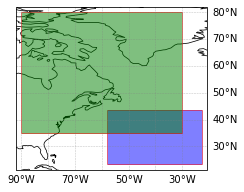


The information from index_history.txt:
-----------------------------------------

index                                                                129
product_id                                                 COP-GLOBAL-01
file_name              ftp://nrt.cmems-du.eu/Core/INSITU_GLO_PHY_UV_D...
geospatial_lat_min                                                23.568
geospatial_lat_max                                                37.565
geospatial_lon_min                                               -67.323
geospatial_lon_max                                               -22.261
time_coverage_start                                 2013-10-20T00:00:00Z
time_coverage_end                                   2016-08-21T12:00:00Z
institution            Atlantic Oceanographic and Meteorological Labo...
date_update                                         2019-03-06T11:03:33Z
data_mode                                                              R
parameters             DEPH WSTN_MODEL W

In [3]:
dataset_to_explore = cmems_dataset1
datafile = cmems_dataset1_datafile
keep_index = explore_the_dataset(dataset_to_explore, 
                                 datafile, 
                                 show_2019=False, 
                                 show_indv_file=True, 
                                 show_representative_plot=True,
                                 save_ftp_links=True)

## Explore CMEMS dataset 2

Note: There appears to be at least some cases where the geospatial_<min/max>_<lon/lats> in the index file do not match the the actual data in the file (example below). It's possible in this case that the original data contained a full track, but the rest of the data was qc'ed out for some reason?

dataset: INSITU_GLO_PHYBGCWAV_DISCRETE_MYNRT_013_030/

datafile: C:/Users/HoldenJe/Drift/projects/gridded_velocity_products/drifter_data/CMEMS/INSITU_GLO_PHYBGCWAV_DISCRETE_MYNRT_013_030/GL_PR_BO_EXO10556.nc


Summary
---------

There were 67638 tracks originally.
49513 tracks have start and/or end dates inside the date range.
Finally, 7073 tracks are in both the right timeframe and cross the NL and LAB shelves.


Representative plot of GL_PR_BO_EXO10556.nc
-----------------------------------------


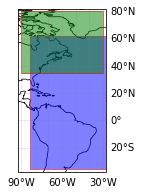


The information from index_history.txt:
-----------------------------------------

index                                                                  4
product_id                                                     COP-AR-01
file_name              ftp://nrt.cmems-du.eu/Core/INSITU_GLO_PHYBGCWA...
geospatial_lat_min                                                 58.85
geospatial_lat_max                                                 71.28
geospatial_lon_min                                                 -38.2
geospatial_lon_max                                                 33.97
time_coverage_start                                 1923-04-13T00:00:00Z
time_coverage_end                                   1931-09-23T00:00:00Z
institution                        Institute of Marine Research (Norway)
date_update                                         2023-01-25T09:26:25Z
data_mode                                                              R
parameters                   PRES TEMP P

In [4]:
dataset_to_explore = cmems_dataset2
datafile = cmems_dataset2_datafile
explore_the_dataset(dataset_to_explore, 
                    datafile, 
                    show_2019=False, 
                    show_indv_file=True, 
                    show_representative_plot=True,
                    save_ftp_links=True)